# Classifying Google Voice Commands Using CNN

### Data Preprocessing and Data Splitting



#### Sample rate conversion 

By default, Librosa’s load function converts the sampling rate to 22.05 KHz. However we want to convert the audio file to 44.1 KHz  

In [2]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np
import os

# PLEASE PUT LOCATION OF WHERE YOU HAVE DOWNLOADED THE GOOGLE VOICE DATASET (should be googleData by default)
dir_name = '../googleData'
# PUT FILEPATH HERE 
filename = os.path.join(dir_name, 'bed/471a0925_nohash_0.wav') 

signal, sr = librosa.load(filename, mono=False, sr=44100) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', sr) 

Original sample rate: 16000
Librosa sample rate: 44100


#### Bit-depth 

Librosa’s load function will also normalise the data in order to keep values in a lower range

In [3]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(signal), 'to', np.max(signal))

Original audio file min~max range: -22368 to 13482
Librosa audio file min~max range: -0.68917257 to 0.41367897


#### Merge audio channels 

Librosa will also convert the signal to mono. 

In [4]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

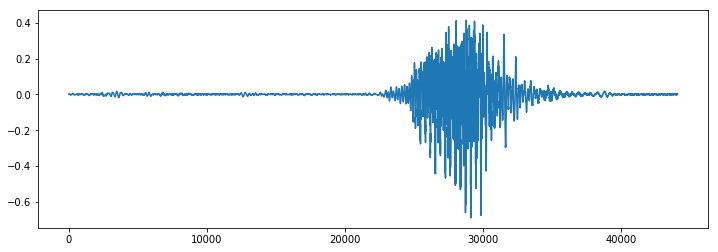

In [5]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(signal)

#### Extracting a Mel Spectrogram

For this we will use [Librosa's melspectrogram() function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html) which generates an spectograms from time series audio data. 

For more information please see this medium blog https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

In [17]:
if len(signal.shape) == 1:
    signal = np.reshape(signal, (1, signal.shape[0]))
melgram = librosa.feature.melspectrogram(signal[0], sr=sr, n_mels=96)
melgram = melgram.astype(np.float16)


Lets take a look at what these images look like for the word "bed"

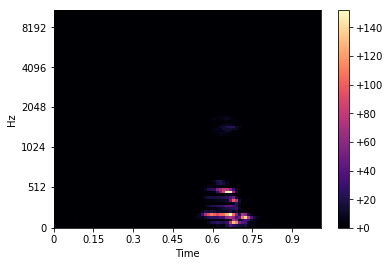

In [21]:
import librosa.display
librosa.display.specshow(melgram, sr=sr, hop_length=512, 
                         x_axis='time',  y_axis='mel');
plt.colorbar(format='%+2.0f');

Now enhance the colour but using the power function

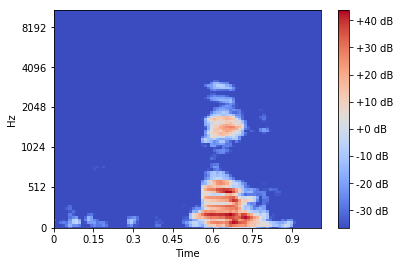

In [19]:
import librosa.display
melgram_db = librosa.amplitude_to_db(melgram)
librosa.display.specshow(melgram_db, sr=sr, hop_length=512, 
                         x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

#### Extracting Melgram's for every file 

Now lets define a function for extracting the melgram for every file in the dataset

In [11]:
import ntpath
def extract_melgram(file_name, save_dir_path=None, sr=44100):
   
    signal, sr = librosa.load(file_name, mono=False, sr=sr)
    if len(signal.shape) == 1:
        signal = np.reshape(signal, (1, signal.shape[0]))
    
    # Make sure all files have the same amount of data by padding empty space with 0
    shape = signal.shape
    max_shape = (1, sr) # Sample Rate is max_shape
    padded_signal = np.zeros(max_shape)     
    use_shape = list(max_shape[:])
    use_shape[0] = min( shape[0], max_shape[0] )
    use_shape[1] = min( shape[1], max_shape[1] )

    padded_signal[:use_shape[0], :use_shape[1]] = signal[:use_shape[0], :use_shape[1]]

    melgram = librosa.amplitude_to_db(librosa.feature.melspectrogram(padded_signal[0], sr=sr, n_mels=96))[np.newaxis,:,:,np.newaxis] 
    melgram = melgram.astype(np.float16)
    if melgram.shape != (1, 96, 87, 1):
        raise Exception('Wrong shape !! {}'.format(melgram.shape))
    
    if save_dir_path:
        npz_path = os.path.join(save_dir_path, ntpath.basename(file_name) + '.npz') 
        np.savez_compressed(npz_path, melgram=melgram)
        
    return melgram

First specify the values for split the training/ test data and also what directory we wish to save the output preoprocessed compressed melgram image files as numpy arrays.

In [12]:
train_percentage = .85
preprocessed_dir = '../Preproc'

Now preproces the data (This may take a while)

In [14]:
# Load various imports 
import pandas as pd
import os, random
import librosa

# Set the path to the full Google Voice Dataset (first you must remove all files that are not wav file)
class_names = [wav_dir for wav_dir in os.listdir(dir_name) if '.' not in wav_dir]

preprocessed_train_dir = os.path.join(preprocessed_dir, 'train')
preprocessed_test_dir = os.path.join(preprocessed_dir, 'test')


if not os.path.exists(preprocessed_dir):
    os.mkdir(preprocessed_dir)

if not os.path.exists(preprocessed_train_dir):
    os.mkdir(preprocessed_train_dir)

if not os.path.exists(preprocessed_test_dir):
    os.mkdir(preprocessed_test_dir)

# Iterate through each  class directory 
for class_dir in sorted(class_names):
    print('Processing Data for class {}'.format(class_dir))
    
    class_files = [file_name for file_name in os.listdir(os.path.join(os.path.abspath(dir_name), class_dir)) 
                                               if 'wav' in file_name]

    train_files = random.sample(class_files, int(len(class_files) * train_percentage))
    test_files = [file_name for file_name in class_files if not file_name in train_files]
    
    proprocessed_class_train_path = os.path.join(preprocessed_train_dir, class_dir)
    proprocessed_class_test_path = os.path.join(preprocessed_test_dir, class_dir)
    
    os.mkdir(proprocessed_class_train_path)
    os.mkdir(proprocessed_class_test_path)
    
    for wav_file in train_files:
        full_wav_file = os.path.join(dir_name, class_dir, wav_file)
        extract_melgram(full_wav_file, proprocessed_class_train_path)
    print('Finished processing training data for class {}'.format(class_dir))
    
    for wav_file in test_files:
        full_wav_file = os.path.join(dir_name, class_dir, wav_file)
        extract_melgram(full_wav_file, proprocessed_class_test_path)
    print('Finished processing test data for class {}'.format(class_dir))
                                               
                          
print('Finished melgram extraction') 

Processing Data for class bed
Finished processing training data for class bed
Finished processing test data for class bed
Processing Data for class bird
Finished processing training data for class bird
Finished processing test data for class bird
Processing Data for class cat
Finished processing training data for class cat
Finished processing test data for class cat
Processing Data for class dog
Finished processing training data for class dog
Finished processing test data for class dog
Processing Data for class down
Finished processing training data for class down
Finished processing test data for class down
Processing Data for class eight
Finished processing training data for class eight
Finished processing test data for class eight
Processing Data for class five
Finished processing training data for class five
Finished processing test data for class five
Processing Data for class four
Finished processing training data for class four
Finished processing test data for class four
Proces

### *Congratulations ! You have preprocessed all the google data*